In [0]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
from google.colab import auth
auth.authenticate_user()

# 구글 드라이브 mount 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My Drive/datasets/DCGAN

/content/gdrive/My Drive/datasets/DCGAN


In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
from keras import initializers
import os
import keras
from keras import layers
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


In [0]:
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
X_train = X_train[y_train.flatten() == 3]

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
# figure를 plt로 visualize
def visualize_rgb(img):
    """
    Visualize a rgb image
    :param img: RGB image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")
    plt.show()

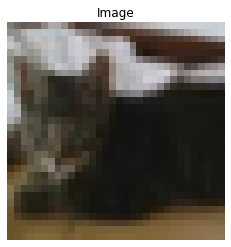

In [0]:
visualize_rgb(X_train[0])

In [0]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100  

In [0]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), activation='relu', kernel_initializer=init))
generator.add(BatchNormalization())
generator.add(Reshape((2, 2, 512)))

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=3, activation='relu', kernel_initializer=init, strides=2, padding='same'))
generator.add(BatchNormalization())

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=3, activation='relu', kernel_initializer=init, strides=2, padding='same'))
generator.add(BatchNormalization())


# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=3, activation='relu', kernel_initializer=init, strides=2, padding='same'))
generator.add(BatchNormalization())

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same',kernel_initializer=init,
                              activation='tanh'))

In [0]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         1179904   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         295040    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)        

In [0]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=3, strides=2, use_bias=False, padding='valid',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))


# Conv 2:
discriminator.add(Conv2D(128, kernel_size=3, strides=2,  kernel_initializer=init, use_bias=False, padding='valid'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=3, strides=2, kernel_initializer=init, use_bias=False, padding='valid'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# discriminator.add(Flatten())
discriminator.add(GlobalAveragePooling2D())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [0]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 64)        1728      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73728     
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 256)        

In [0]:
# Optimizer
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
gan_model = Model(inputs=z, outputs=decision)

gan_model.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [0]:
def normalize(img):
    return (img - 127.5) / 127.5

In [0]:
def denormalize(img):
    img = (img * 127.5) + 127.5
    return img.astype(np.uint8)

In [0]:
print(X_train.shape)

(5000, 32, 32, 3)


In [0]:
# 데이터를 정규화합니다
X_train = normalize(X_train)

iterations = 5000
batch_size = 20
save_dir = os.path.join("./", 'gan_images')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [0]:
epochs = 5000
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = gan_model.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 3 == 0:
      gan_model.save_weights('gan.h5')

      img = image.array_to_img(denormalize(X_fake[0]), scale=False)
      img.save(os.path.join(save_dir, 'generated' + str(e) + '.png'))

      img = image.array_to_img(denormalize(X_batch[0]), scale=False)
      img.save(os.path.join(save_dir, 'real' + str(e) + '.png'))
       

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
epoch = 3/5000, d_loss=1.259, g_loss=0.932                                                                                                     
epoch = 4/5000, d_loss=1.322, g_loss=0.879                                                                                                     
epoch = 5/5000, d_loss=1.415, g_loss=0.885                                                                                                     
epoch = 6/5000, d_loss=1.383, g_loss=0.871                                                                                                     
epoch = 7/5000, d_loss=1.392, g_loss=0.899                                                                                                     
epoch = 8/5000, d_loss=1.318, g_loss=0.889                                                                                                     
epoch = 9/5000, d_loss=1.385, g_loss=0.896                                                          